In [10]:
%load_ext autoreload
%autoreload 2

import itertools
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.transforms import ScaledTranslation, Bbox
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, MultipleLocator, FixedLocator
from scipy.stats import laplace
from pyprojroot.here import here

from lib_canonical import find_breakpoint
from lib_fit_models import simulate_trajectories_using_mode_regression, simulate_trajectories_using_fixed_mode, sample_trunc_laplace, trajectories_to_dataframe, sample_trunc_laplace_resample_list

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
colors = ['#EF476F', '#118AB2', '#06D6A0', '#073B4C', '#FFD166']
sns.set_palette(colors)

sns.set_context("talk")

In [4]:
def make_parameters(alpha1, alpha2):
    return [
        {'cutoffs': (4, ), 'cutoff_start': 0, 'cutoff_end': 4, 'alpha': alpha1},
        {'cutoffs': (4, ), 'cutoff_start': 4, 'cutoff_end': np.inf, 'alpha': alpha2},
    ]


def prop_trajectories_canonical(trajectories):
    breakpoints = np.array(find_breakpoints_vectorized(trajectories.T)).T
    
    num_canonical = 0

    for tstar, m1, m2 in breakpoints:
        if tstar == -1:
            continue

        num_canonical += (m1 > 0 and m2 < 0 and m1 > -2*m2 and tstar < 10)

    prop_canonical = num_canonical / trajectories.shape[1]
    
    return prop_canonical


def marker_settings(edgecolor, markersize=10):
    return dict(marker='o', markerfacecolor='white', markeredgecolor=edgecolor, markersize=markersize, markeredgewidth=2)

    
def plot_trajectories(ax, trajs, label='Simulation', estimator=np.mean, linestyle='--', color=None, markersize=10):
    
    if color:
        extra_settings = marker_settings(color)
    else:
        extra_settings = dict(marker='o', markersize=markersize)
    
    total_years = 20
    sns.lineplot(x=itertools.chain(*[itertools.repeat(i, trajs.shape[1]) for i in range(total_years + 1)]), y=trajs.flatten(), estimator=estimator, label=label, ax=ax, linestyle=linestyle, lw=4, **extra_settings)
    

find_breakpoints_vectorized = np.vectorize(find_breakpoint, signature='(n)->(),(),()')

In [5]:
lowest_alpha = 0.1
highest_alpha = 5
steps = 20

interval = np.linspace(lowest_alpha, highest_alpha, steps)
alpha_grid = list(itertools.product(interval, interval))

In [6]:
global_mode = 0.646
alpha_q0 = 4.65

In [7]:
lowest_alpha_fixed = 0.1
highest_alpha_fixed = 5
steps = 20
global_mode_fixed = -1

interval_fixed = np.linspace(lowest_alpha_fixed, highest_alpha_fixed, steps)
alpha_grid_fixed = list(itertools.product(interval_fixed, interval_fixed))

results_fixed = []

for alpha1, alpha2 in alpha_grid_fixed:
    trajectories = simulate_trajectories_using_fixed_mode(make_parameters(alpha1, alpha2), alpha_q0, global_mode=global_mode_fixed, n=400)
    prop_canonical = prop_trajectories_canonical(trajectories)
    
    results_fixed.append((alpha1, alpha2, prop_canonical))

In [8]:
df_results_fixed = pd.DataFrame(results_fixed, columns=['x', 'y', 'value'])
df_results_fixed['x'] = df_results_fixed['x'].round(1)
df_results_fixed['y'] = df_results_fixed['y'].round(1)

df_results_fixed_pivot = df_results_fixed.pivot(index='y', columns='x', values='value').sort_index(level=0, ascending=False)

In [102]:
heatmap_labels = np.array([0.1, 0.4, 0.6, 0.9, 1.1, 1.4, 1.6, 1.9, 2.2, 2.4, 2.7, 2.9, 3.2,
       3.5, 3.7, 4. , 4.2, 4.5, 4.7, 5. ])

shown_labels = heatmap_labels[::2] * 4
minor_labels = heatmap_labels[1::2] * 4
minor_labels_shifted = (heatmap_labels[1::2] - heatmap_labels[1]) * 4
shown_labels_loc = (np.concatenate(([0], minor_labels))[:-1] + minor_labels)/2
shown_labels_loc_shifted = (np.concatenate(([0], minor_labels_shifted))[:-1] + minor_labels_shifted)/2

In [115]:
heatmap_labels[:-1] - heatmap_labels[1:]

array([-0.3, -0.2, -0.3, -0.2, -0.3, -0.2, -0.3, -0.3, -0.2, -0.3, -0.2,
       -0.3, -0.3, -0.2, -0.3, -0.2, -0.3, -0.2, -0.3])

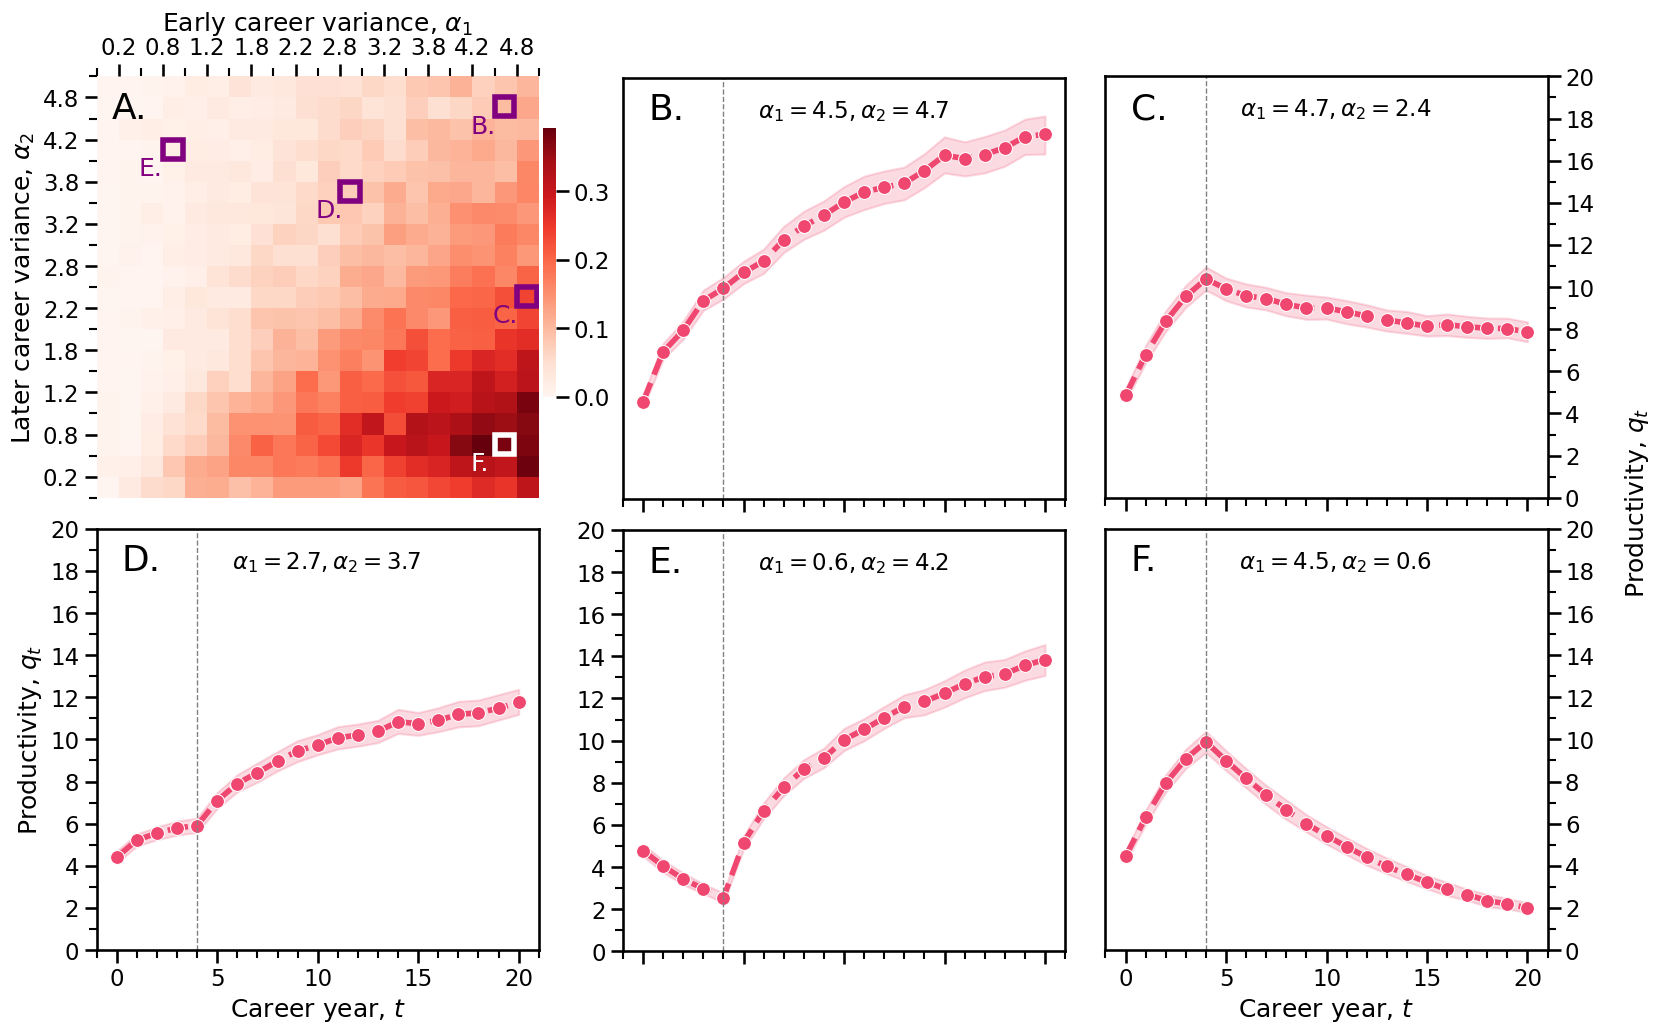

In [163]:
def data_to_grid_space(axis, alpha1, alpha2):
    x_ix = np.where(heatmap_labels == alpha1)[0][0]
    y_ix = np.where(heatmap_labels == alpha2)[0][0]
    return x_ix + 1, len(heatmap_labels) - y_ix - 1


def annotate_square(axis, alpha1, alpha2, inset_loc, color="black"):
    ic = data_to_grid_space(ax_A, inset_loc[0], inset_loc[1])
    xy = data_to_grid_space(ax_A, alpha1, alpha2)
    axis.add_patch(patches.Rectangle(xy, 0.9, 0.9, edgecolor=color, lw=4, fill=False))
    axis.add_patch(patches.FancyArrow(xy[0] + 0.5, xy[1] + 0.5, ic[0] - xy[0], ic[1] - xy[1], color=color, width=0.001, head_length=0.5, head_width=0.5))

def annotate_square_lab(axis, alpha1, alpha2, lab, color="purple"):
    xy = data_to_grid_space(ax_A, alpha1, alpha2)
    axis.add_patch(patches.Rectangle(xy, 0.9, 0.9, edgecolor=color, lw=4, fill=False))
    axis.text(xy[0] - 1.1, xy[1] + 1.7, lab, color=color)

inset_width = "30%"
inset_height = "47%"

def stylize_axis(axis, loc='upper center', lab='A.'):
    axis.set_facecolor("none")
    axis.set_ylim([0, 20])
    axis.legend(frameon=False, loc=loc, handlelength=0, markerscale=0)
    axis.vlines(x=4, ymin=0, ymax=20, linestyle='--', color='gray', lw=1)
    
    major_locator = MaxNLocator(nbins=10)
    minor_locator = MaxNLocator(nbins=20)
    axis.yaxis.set_major_locator(major_locator)
    axis.yaxis.set_minor_locator(minor_locator)
    axis.text(0.25, 18, lab, fontsize="x-large")

def setup_xticks(axis, show_labels=False):
    major_locator = MaxNLocator(nbins=5)
    minor_locator = MaxNLocator(nbins=20, min_n_ticks=20, integer=True)
    axis.xaxis.set_major_locator(major_locator)
    axis.xaxis.set_minor_locator(minor_locator)

    if show_labels:
        axis.set_xlabel("Career year, $t$")
    else:
        for label in axis.get_xticklabels():
            label.set_visible(False)
    
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
plt.tight_layout()
ax.set_axis_off()


ax_A = inset_axes(ax, width=inset_width, height=inset_height, loc="upper left")


#ax_A.yaxis.set_minor_locator(FixedLocator(shown_labels))
#ax_A.xaxis.set_minor_locator(FixedLocator(shown_labels))

g = sns.heatmap(
    df_results_fixed_pivot,
    cmap='Reds',
    ax=ax_A,
    cbar=True,
    xticklabels=False,
    yticklabels=False,
    cbar_kws = {
        'shrink': 0.3,
        'anchor': (-3.83, 0.9)
    }
)
#ax_A.set_xticks(minor_labels - (minor_labels[1] - minor_labels[0]))
#ax_A.set_xticks(shown_labels)
#ax_A.set_yticks(shown_labels)
#ax_A.set_yticklabels(shown_labels[::-1] / 4)

heatmap_grid = np.linspace(0, heatmap_labels[-1]*4, 11)

heatmap_grid_delta = heatmap_grid[1] - heatmap_grid[0]
heatmap_grid_major = heatmap_grid + (heatmap_grid_delta)/2
ax_A.set_xticks(heatmap_grid_major)
ax_A.set_yticks(heatmap_grid_major)
ax_A.set_xticklabels((heatmap_grid_major / 4).round(1))
ax_A.set_yticklabels(((heatmap_grid_major[::-1] - heatmap_grid_delta) / 4).round(1))


ax_A.yaxis.set_minor_locator(FixedLocator(heatmap_grid))
ax_A.xaxis.set_minor_locator(FixedLocator(heatmap_grid))
ax_A.set_xlim([0, heatmap_labels[-1]*4])
ax_A.set_ylim([heatmap_labels[-1]*4, 0])

ax_A.set_xlabel("Early career variance, $\\alpha_1$")
ax_A.set_ylabel("Later career variance, $\\alpha_2$")
ax_A.xaxis.set_ticks_position('top')
ax_A.xaxis.set_label_position('top') 
ax_A.text(0.7, 2, "A.", fontsize="x-large")

#heatmap_labels = np.array([float(x.get_text()) for x in ax_A.get_xticklabels()])

#for label in ax_A.get_xticklabels()[1::2]:
#    label.set_visible(False)

#for label in ax_A.get_yticklabels()[::2]:
#    label.set_visible(False)



ax1 = inset_axes(ax, width=inset_width, height=inset_height, loc="lower right")
plot_trajectories(ax1, simulate_trajectories_using_fixed_mode(
    make_parameters(4.5, 0.6), alpha_q0, global_mode=global_mode_fixed, n=1000), label="$\\alpha_1=4.5, \\alpha_2=0.6$")
ax1.set_ylabel(None)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
setup_xticks(ax1, show_labels=True)
stylize_axis(ax1, lab="F.")

ax2 = inset_axes(ax, width=inset_width, height=inset_height, loc="upper right")
plot_trajectories(ax2, simulate_trajectories_using_fixed_mode(
    make_parameters(4.7, 2.4), alpha_q0, global_mode=global_mode_fixed, n=1000), label="$\\alpha_1=4.7, \\alpha_2=2.4$"),
ax2.set_ylabel("Productivity, $q_t$")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_coords(1.17, -0.01)

setup_xticks(ax2)
stylize_axis(ax2, lab="C.")

shift_trans = ScaledTranslation(-0.04, -0.0765, ax.transAxes)
ax3 = inset_axes(ax, width=inset_width, height=inset_height, loc="upper center", bbox_transform=shift_trans)
plot_trajectories(ax3, simulate_trajectories_using_fixed_mode(
    make_parameters(4.5, 4.7), alpha_q0, global_mode=global_mode_fixed, n=1000), label="$\\alpha_1=4.5, \\alpha_2=4.7$")
ax3.set_ylabel(None)
ax3.set_yticklabels([])
setup_xticks(ax3)
ax3.yaxis.set_ticks_position('none')
stylize_axis(ax3, lab="B.")

ax5 = inset_axes(ax, width="30%", height="47%", loc="lower center", bbox_transform=shift_trans)
plot_trajectories(ax5, simulate_trajectories_using_fixed_mode(
    make_parameters(0.6, 4.2), alpha_q0, global_mode=global_mode_fixed, n=1000), label="$\\alpha_1=0.6, \\alpha_2=4.2$")
shift_trans_lab = ScaledTranslation(0, -0.3, ax.transAxes)

setup_xticks(ax5)
stylize_axis(ax5, lab="E.")

ax4 = inset_axes(ax, width=inset_width, height=inset_height, loc="lower left")

plot_trajectories(ax4, simulate_trajectories_using_fixed_mode(
    make_parameters(2.7, 3.7), alpha_q0, global_mode=global_mode_fixed, n=1000), label="$\\alpha_1=2.7, \\alpha_2=3.7$")
setup_xticks(ax4, show_labels=True)
ax4.set_ylabel("Productivity, $q_t$")
stylize_axis(ax4, lab="D.")


#annotate_square(ax_A, 4.5, 0.6, inset_loc=(5, 0.6), color="white")
#annotate_square(ax_A, 4.7, 2.4, inset_loc=(5,5))
#annotate_square(ax_A, 4.5, 4.7, inset_loc=(4.2, 5))
#annotate_square(ax_A, 2.7, 3.7, inset_loc=(0.1, 5))
#annotate_square(ax_A, 0.6, 4.2, inset_loc=(0.1, 4.2))

annotate_square_lab(ax_A, 4.5, 0.6, lab="F.", color="white") 
annotate_square_lab(ax_A, 4.7, 2.4, lab="C.") 
annotate_square_lab(ax_A, 4.5, 4.7, lab="B.") 
annotate_square_lab(ax_A, 2.7, 3.7, lab="D.") 
annotate_square_lab(ax_A, 0.6, 4.2, lab="E.") 

plt.savefig(here("fit/output/heatmap.pdf"), bbox_inches='tight')

Second plot: $q_t$ vs $\delta_t$ for a fixed global value of $\beta$ and two possible values of $\alpha$.

In [10]:
def trunc_laplace_expectation(alpha, k):
    exp_term = np.exp(-k/alpha)
    return alpha * (2*k/alpha + exp_term) / (2 - exp_term)

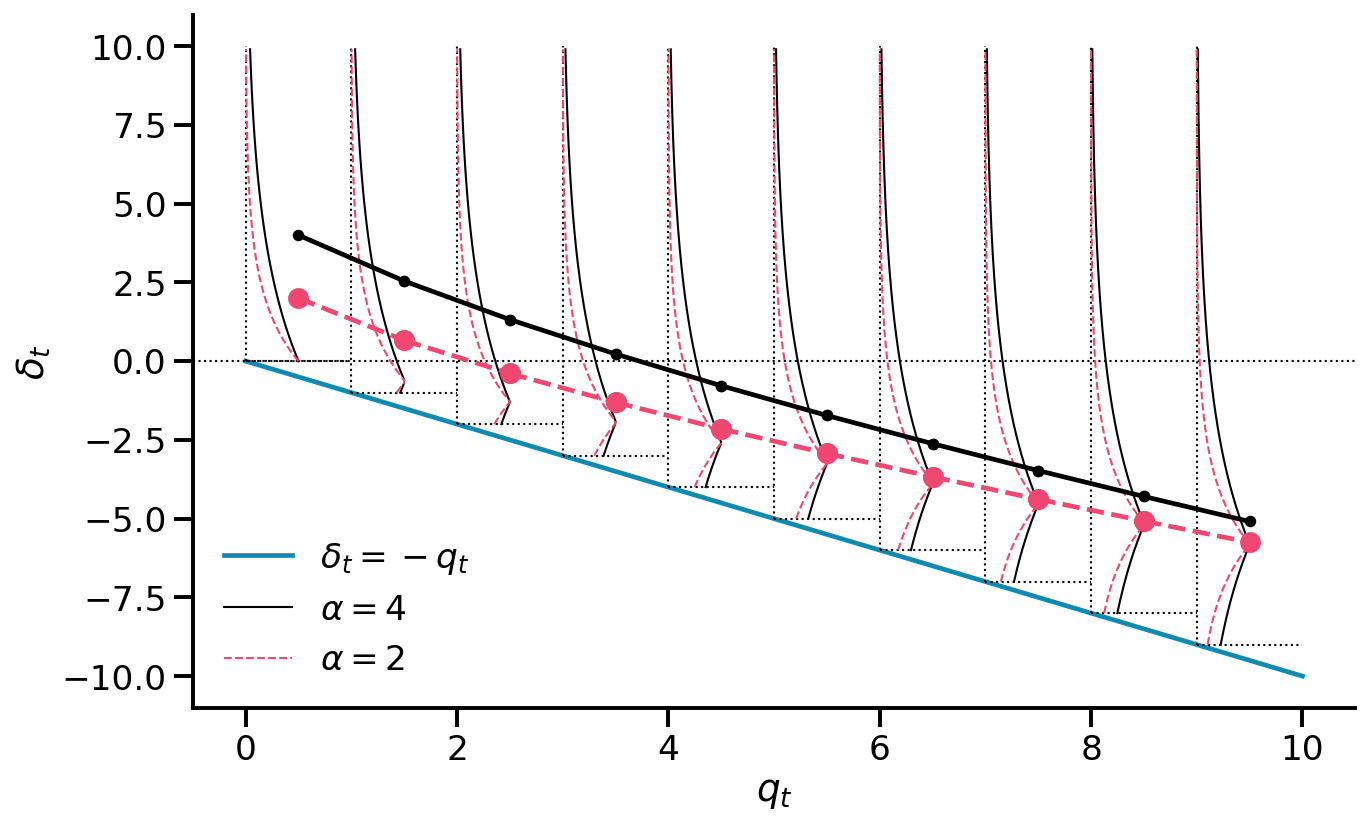

In [11]:
#q_t = np.linspace(0, 20, 3)

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)


upper = 10
step = 1

intervals = np.arange(0, upper, step)


ax.plot([0, step*(upper // step)], [0, -step*(upper // step)], color=colors[1], label="$\\delta_t = -q_t$")
ax.vlines(intervals, ymin=-intervals, ymax=upper, linestyle='dotted', lw=1, color='black')
ax.axhline(0, color='black', lw=1, linestyle='dotted')

ax.hlines(-intervals, xmin=intervals, xmax=intervals + step, color='black', lw=1, linestyle='dotted')


last_mu1 = None
last_mu2 = None

for interval in intervals:
    rv = laplace(loc=-interval*global_mode, scale=4)
    x = np.arange(-interval, upper, 0.1)
    y = rv.pdf(x)
    mu1 = -global_mode * interval + trunc_laplace_expectation(4, interval) - interval

    label1 = None
    label2 = None
    if interval == 0:
        label1 = "$\\alpha=4$"
        label2 = "$\\alpha=2$"
    ax.plot(interval + y / y.max() * step/2, x, color='black', lw=1, label=label1)

    rv = laplace(loc=-interval*global_mode, scale=2)
    y2 = rv.pdf(x)
    mu2 = -global_mode * interval + trunc_laplace_expectation(2, interval) - interval

    ax.plot(interval + y2 / y2.max() * step/2, x, color=colors[0], lw=1, linestyle='dashed', label=label2)
    
    # plot means
    #ax.hlines(mu1, xmin=interval + 2*step/3, xmax=interval + 2.5*step/3, color='black', lw=2)
    #ax.hlines(mu2, xmin=interval + 2*step/3, xmax=interval + 2.5*step/3, color=colors[0], linestyle='dashed', lw=2)
    
    if last_mu1 is not None:
        ax.plot([interval - step/2, interval + step/2], [last_mu1, mu1], color='black', marker='.')
        ax.plot([interval - step/2, interval + step/2], [last_mu2, mu2], color=colors[0], marker='o', linestyle='dashed')
        
    last_mu1 = mu1
    last_mu2 = mu2
ax.legend(loc='lower left', frameon=False)
ax.set_xlabel("$q_t$")
ax.set_ylabel("$\delta_t$")
sns.despine()

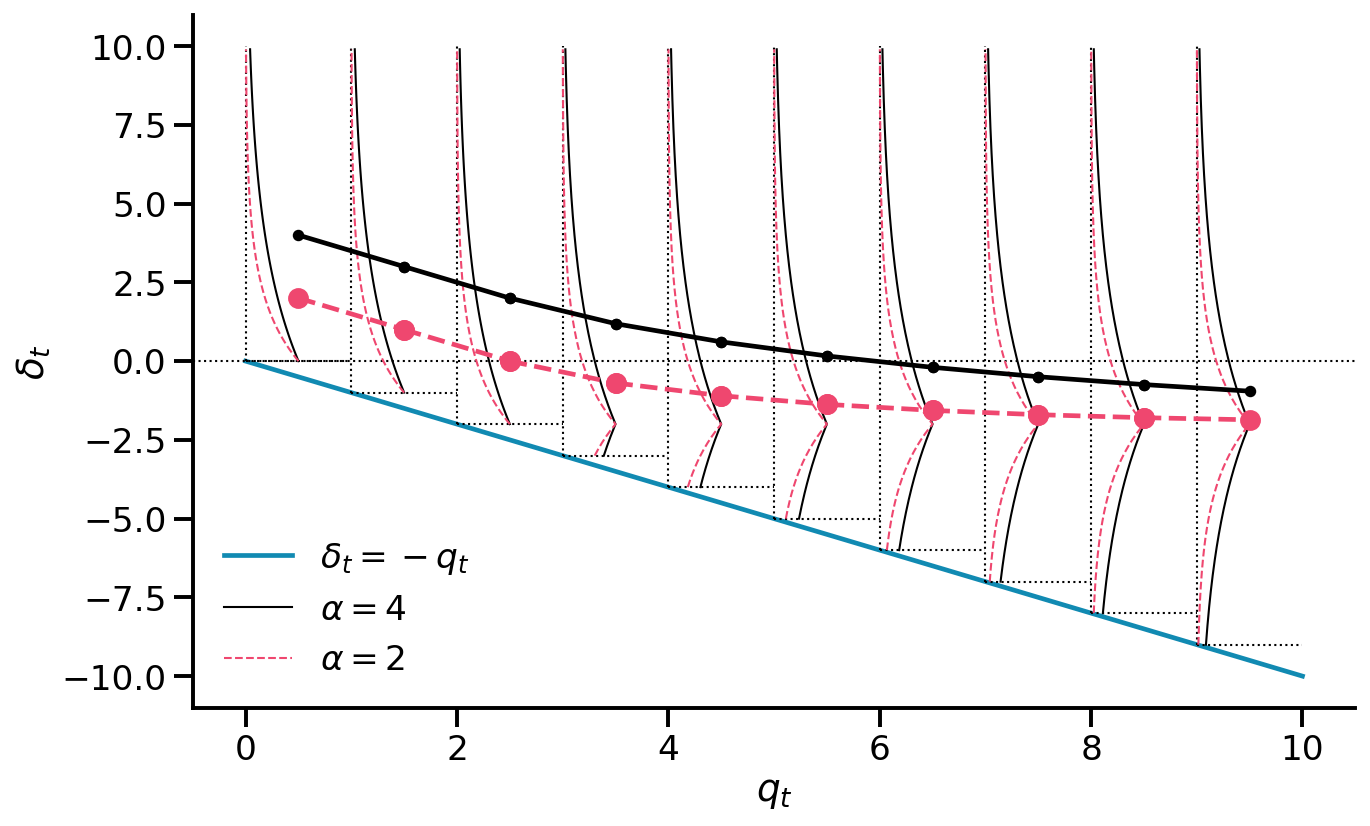

In [12]:
#q_t = np.linspace(0, 20, 3)

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)


upper = 10
step = 1
global_mode_fixed = -2

intervals = np.arange(0, upper, step)


ax.plot([0, step*(upper // step)], [0, -step*(upper // step)], color=colors[1], label="$\\delta_t = -q_t$")
ax.vlines(intervals, ymin=-intervals, ymax=upper, linestyle='dotted', lw=1, color='black')
ax.axhline(0, color='black', lw=1, linestyle='dotted')

ax.hlines(-intervals, xmin=intervals, xmax=intervals + step, color='black', lw=1, linestyle='dotted')

last_mu1 = None
last_mu2 = None

for interval in intervals:
    rv = laplace(loc=global_mode_fixed, scale=4)
    x = np.arange(-interval, upper, 0.1)
    y = rv.pdf(x)
    mu1 = trunc_laplace_expectation(4, max(interval + global_mode_fixed, 0)) - interval

    label1 = None
    label2 = None
    if interval == 0:
        label1 = "$\\alpha=4$"
        label2 = "$\\alpha=2$"
    ax.plot(interval + y / y.max() * step/2, x, color='black', lw=1, label=label1)

    rv = laplace(loc=global_mode_fixed, scale=2)
    y2 = rv.pdf(x)
    mu2 = trunc_laplace_expectation(2, max(interval + global_mode_fixed, 0)) - interval

    ax.plot(interval + y2 / y2.max() * step/2, x, color=colors[0], lw=1, linestyle='dashed', label=label2)
    
    # plot means
    #ax.hlines(mu1, xmin=interval + 2*step/3, xmax=interval + 2.5*step/3, color='black', lw=2)
    #ax.hlines(mu2, xmin=interval + 2*step/3, xmax=interval + 2.5*step/3, color=colors[0], linestyle='dashed', lw=2)
    
    if last_mu1 is not None:
        ax.plot([interval - step/2, interval + step/2], [last_mu1, mu1], color='black', marker='.')
        ax.plot([interval - step/2, interval + step/2], [last_mu2, mu2], color=colors[0], marker='o', linestyle='dashed')
        
    last_mu1 = mu1
    last_mu2 = mu2
    
ax.legend(loc='lower left', frameon=False)
ax.set_xlabel("$q_t$")
ax.set_ylabel("$\delta_t$")
sns.despine()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


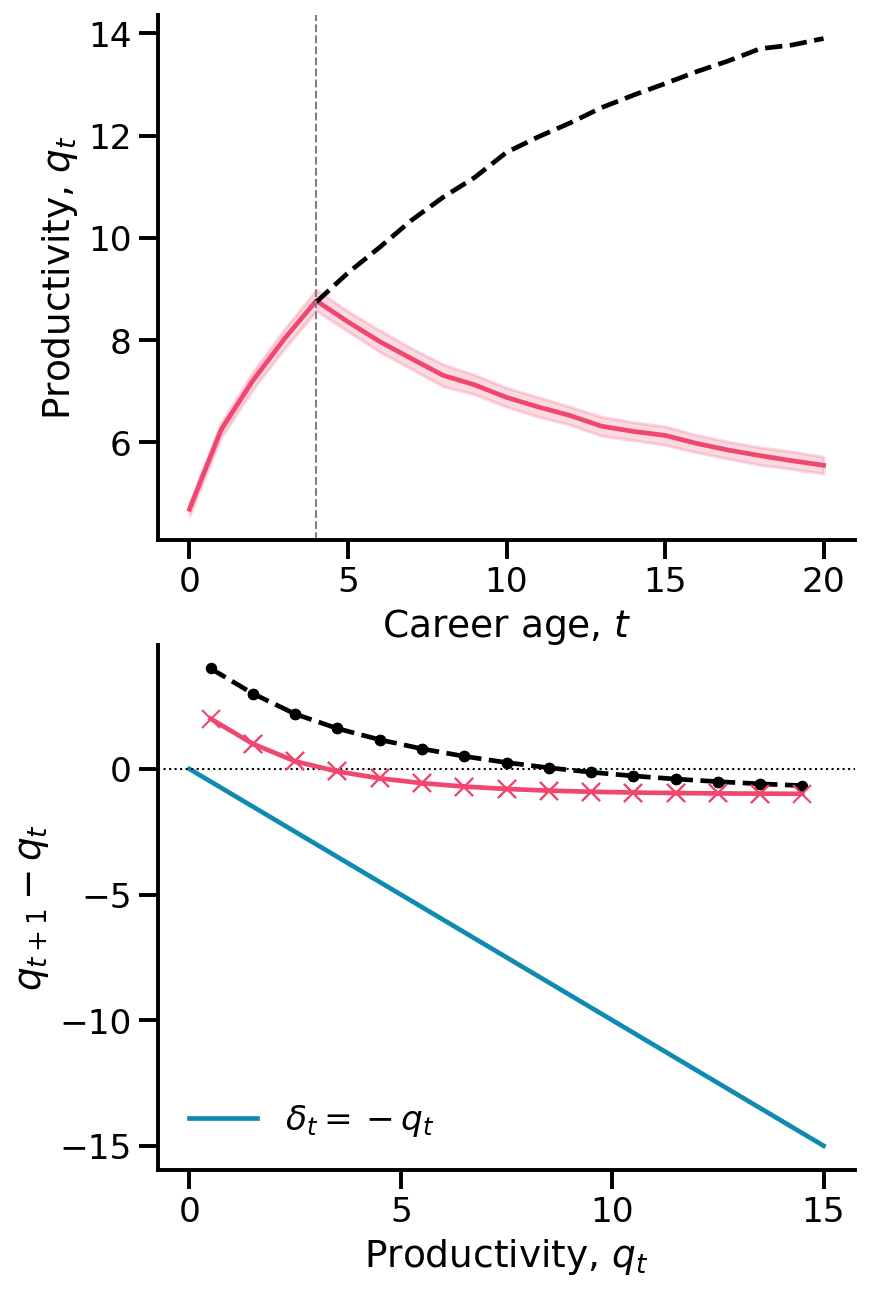

In [13]:
global_mode_fixed = -1
scale_big = 4
scale_small = 2

fig, axes = plt.subplots(2, 1, figsize=(6, 10), dpi=150)

canonical = simulate_trajectories_using_fixed_mode(make_parameters(scale_big, scale_small), alpha_q0, global_mode=global_mode_fixed, n=5000)
continuation = simulate_trajectories_using_fixed_mode(make_parameters(scale_big, scale_big), alpha_q0, global_mode=global_mode_fixed, n=5000)[4:,]

ax = axes[0]

canonical_x = itertools.chain(*[itertools.repeat(i, canonical.shape[1]) for i in range(canonical.shape[0])])
canonical_y = canonical.flatten()

continuation_x = itertools.chain(*[itertools.repeat(4 + i, continuation.shape[1]) for i in range(continuation.shape[0])])
continuation_y = continuation.flatten()

sns.lineplot(ax=ax, x=canonical_x, y=canonical_y, label=None, color=colors[0])
sns.lineplot(ax=ax, x=continuation_x, y=continuation_y, label=None, color="black", linestyle='--', errorbar=None)

ax.axvline(4, linestyle='--', color='gray', lw=1)

ax.set_xlabel("Career age, $t$")
ax.set_ylabel("Productivity, $q_t$")
ax.legend(frameon=False)

#ax.text(-0.5, 3.4, "High\nvariance", fontsize="small")
#ax.text(4.5, 3.65, "Low variance", fontsize="small")
#ax.set_ylim([3.2, 14])






ax = axes[1]

upper = 15
step = 1


intervals = np.arange(0, upper, step)


ax.plot([0, step*(upper // step)], [0, -step*(upper // step)], color=colors[1], label="$\\delta_t = -q_t$")
#ax.vlines(intervals, ymin=-intervals, ymax=upper, linestyle='dotted', lw=1, color='black')
ax.axhline(0, color='black', lw=1, linestyle='dotted')

#ax.hlines(-intervals, xmin=intervals, xmax=intervals + step, color='black', lw=1, linestyle='dotted')

last_mu1 = None
last_mu2 = None


for interval in intervals:
    rv = laplace(loc=global_mode_fixed, scale=scale_big)
    x = np.arange(-interval, upper, 0.1)
    y = rv.pdf(x)
    mu1 = trunc_laplace_expectation(scale_big, max(interval + global_mode_fixed, 0)) - interval

    label1 = None
    label2 = None
    if interval == 0:
        label1 = f"$\\alpha={scale_big}$"
        label2 = f"$\\alpha={scale_small}$"
    #ax.plot(interval + y / y.max() * step/2, x, color='black', lw=1, label=label1)

    rv = laplace(loc=global_mode_fixed, scale=scale_small)
    y2 = rv.pdf(x)
    mu2 = trunc_laplace_expectation(scale_small, max(interval + global_mode_fixed, 0)) - interval

    #ax.plot(interval + y2 / y2.max() * step/2, x, color=colors[0], lw=1, linestyle='dashed', label=label2)
    
   
    if last_mu1 is not None:
        ax.plot([interval - step/2, interval + step/2], [last_mu1, mu1], color="black", marker='.', linestyle="dashed")
        ax.plot([interval - step/2, interval + step/2], [last_mu2, mu2], color=colors[0], marker='x')
        
    last_mu1 = mu1
    last_mu2 = mu2
    
ax.legend(loc='lower left', frameon=False)
ax.set_xlabel("Productivity, $q_t$")
ax.set_ylabel("$q_{t+1} - q_t$")
sns.despine()

In [14]:
prods = [alpha_q0]

for i in range(100):
        new_mu = trunc_laplace_expectation(scale_big, max(prods[-1] + global_mode_fixed, 0))
        #new_mu = trunc_laplace_expectation(scale_big, prods[-1])
        prods.append(new_mu)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


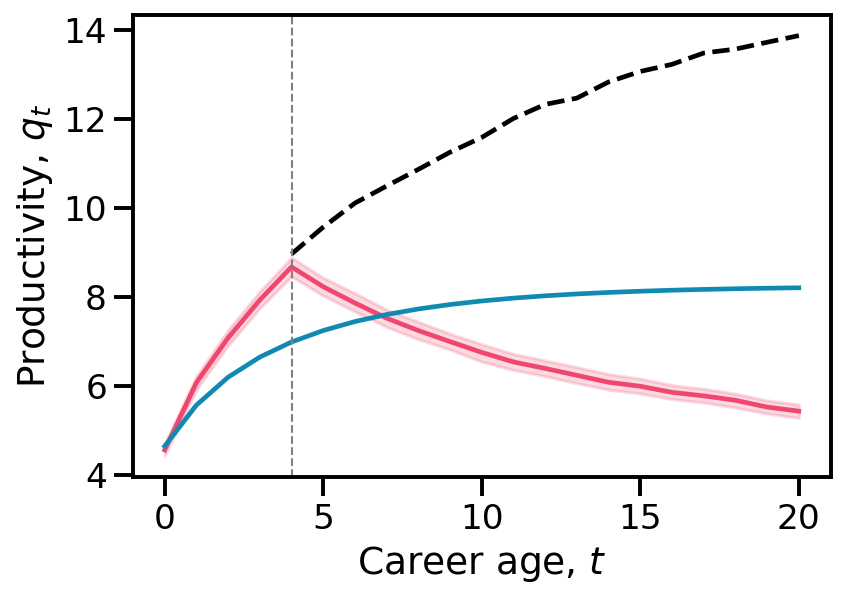

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)

canonical = simulate_trajectories_using_fixed_mode(make_parameters(scale_big, scale_small), alpha_q0, global_mode=global_mode_fixed, n=5000)
continuation = simulate_trajectories_using_fixed_mode(make_parameters(scale_big, scale_big), alpha_q0, global_mode=global_mode_fixed, n=5000)[4:,]

canonical_x = itertools.chain(*[itertools.repeat(i, canonical.shape[1]) for i in range(canonical.shape[0])])
canonical_y = canonical.flatten()

continuation_x = itertools.chain(*[itertools.repeat(4 + i, continuation.shape[1]) for i in range(continuation.shape[0])])
continuation_y = continuation.flatten()

sns.lineplot(ax=ax, x=canonical_x, y=canonical_y, label=None, color=colors[0])
ax.plot(range(21), prods[:21], color=colors[1])
sns.lineplot(ax=ax, x=continuation_x, y=continuation_y, label=None, color="black", linestyle='--', errorbar=None)

ax.axvline(4, linestyle='--', color='gray', lw=1)

ax.set_xlabel("Career age, $t$")
ax.set_ylabel("Productivity, $q_t$")
ax.legend(frameon=False)


3.574802473229844 3.6278742402624973


<AxesSubplot: ylabel='Count'>

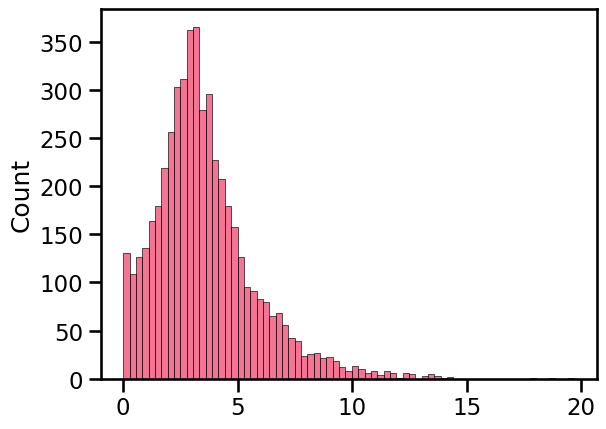

In [16]:
data = sample_trunc_laplace_resample_list(np.repeat(3, 5000), 2, 0)
print(np.mean(data), trunc_laplace_expectation(2, 3))

sns.histplot(data)

Text(0.5, 0.98, 'Trunc Laplace with $\\alpha=4$')

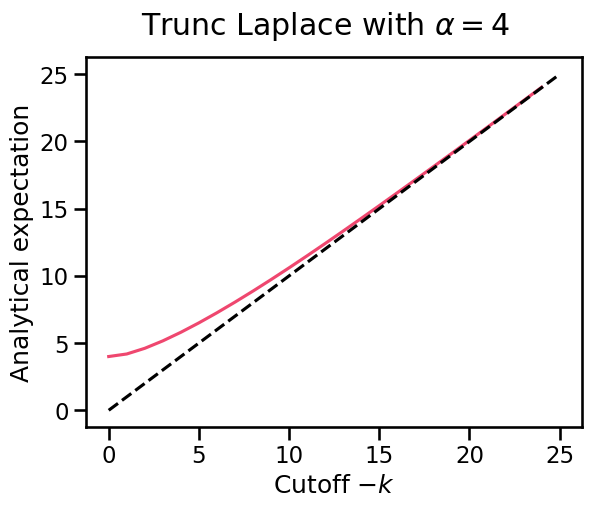

In [17]:
plt.plot(range(25), [trunc_laplace_expectation(scale_big, x) for x in range(25)])
plt.plot([0, 25], [0, 25], color='black', linestyle='dashed')
plt.xlabel("Cutoff $-k$")
plt.ylabel("Analytical expectation")
plt.suptitle("Trunc Laplace with $\\alpha=4$")

In [18]:
continuation = simulate_trajectories_using_fixed_mode(make_parameters(scale_big, scale_big), 30, global_mode=global_mode_fixed, n=2, Y=50000)

In [19]:
trunc_laplace_expectation(4, 10 - 1) - 10

-0.27679227356624914

-0.07952274483531385


<AxesSubplot: ylabel='Count'>

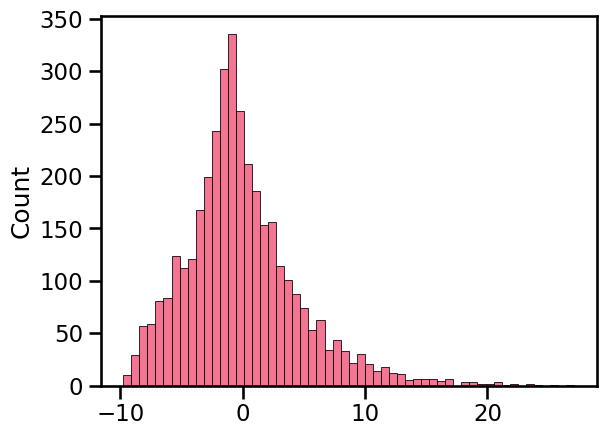

In [20]:
continuation_bin_ix = np.where((continuation[:-1, 0] > 8) & (continuation[:-1, 0] < 10))[0]
bin_diffs = continuation[:,0][continuation_bin_ix + 1] - continuation[:,0][continuation_bin_ix]

print(np.mean(bin_diffs))
sns.histplot(bin_diffs)

[17.36107337 17.31265307]


<AxesSubplot: ylabel='Count'>

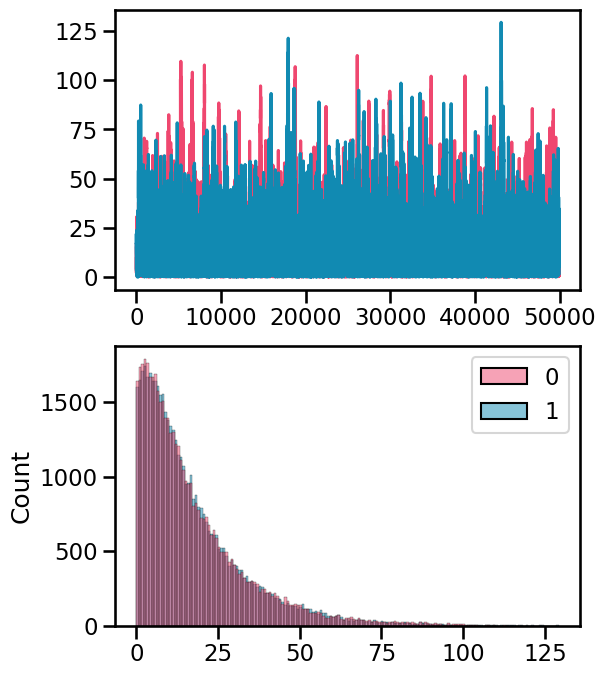

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

print(continuation[100:].mean(axis=0))

ax = axes[0]
ax.plot(range(len(continuation[100:])), continuation[100:])

ax = axes[1]
sns.histplot(continuation[100:], ax=ax)

Text(0, 0.5, 'Windowed average')

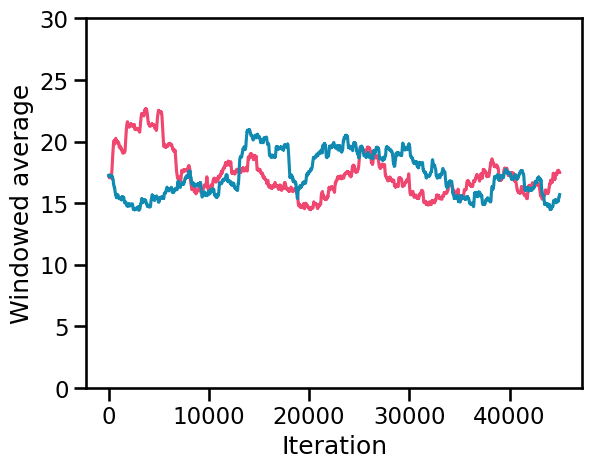

In [22]:
avgs = []
avgs2 = []
window = 5000
for i in range(len(continuation[:-window, 0])):
    avgs.append(np.mean(continuation[i:i + window, 0]))
    avgs2.append(np.mean(continuation[i:i + window, 1]))
    
plt.plot(range(len(avgs)), avgs)
plt.plot(range(len(avgs)), avgs2)
plt.ylim([0, 30])
plt.xlabel("Iteration")
plt.ylabel("Windowed average")

/Users/shzh8108/research/clauset/trajectories-clean/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shzh8108/research/clauset/trajectories-clean/venv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Running average')

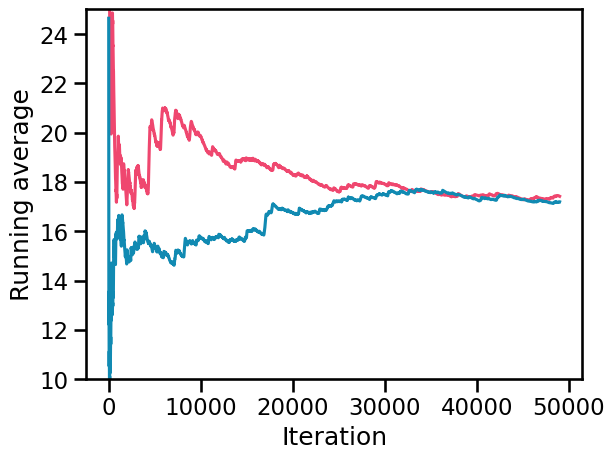

In [23]:
avgs = []
avgs2 = []

for i in range(1000, len(continuation)):
    avgs.append(np.mean(continuation[1000:i, 0]))
    avgs2.append(np.mean(continuation[1000:i, 1]))
    
plt.plot(range(len(avgs)), avgs)
plt.plot(range(len(avgs)), avgs2)
plt.ylim([10, 25])
plt.xlabel("Iteration")
plt.ylabel("Running average")

Text(0, 0.5, 'Running average (from end)')

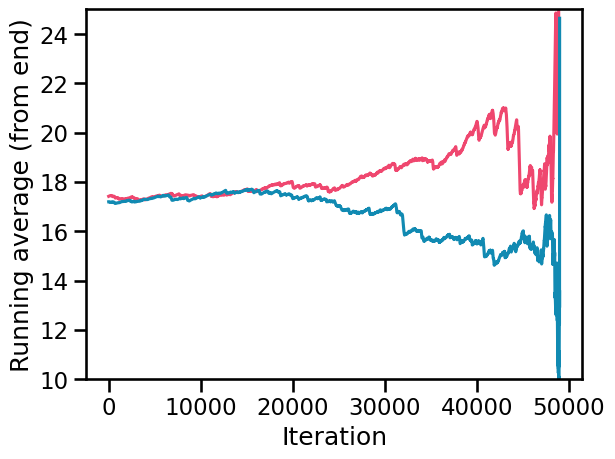

In [24]:
avgs = []
avgs2 = []

for i in range(0, len(continuation) - 1000):
    avgs.append(np.mean(continuation[1000:len(continuation) - i, 0]))
    avgs2.append(np.mean(continuation[1000:len(continuation) - i, 1]))
    
plt.plot(range(len(avgs)), avgs)
plt.plot(range(len(avgs)), avgs2)
plt.ylim([10, 25])
plt.xlabel("Iteration")
plt.ylabel("Running average (from end)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


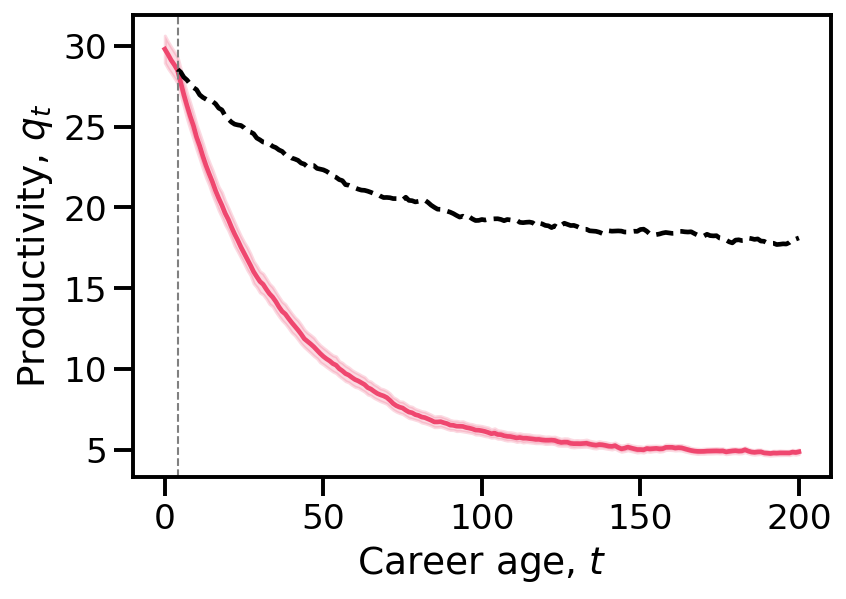

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)

canonical = simulate_trajectories_using_fixed_mode(make_parameters(scale_big, scale_small), 30, global_mode=global_mode_fixed, n=5000, Y=200)
continuation = simulate_trajectories_using_fixed_mode(make_parameters(scale_big, scale_big), 30, global_mode=global_mode_fixed, n=5000, Y=200)[4:,]

canonical_x = itertools.chain(*[itertools.repeat(i, canonical.shape[1]) for i in range(canonical.shape[0])])
canonical_y = canonical.flatten()

continuation_x = itertools.chain(*[itertools.repeat(4 + i, continuation.shape[1]) for i in range(continuation.shape[0])])
continuation_y = continuation.flatten()

sns.lineplot(ax=ax, x=canonical_x, y=canonical_y, label=None, color=colors[0])
#ax.plot(range(len(prods)), prods, color=colors[1])
sns.lineplot(ax=ax, x=continuation_x, y=continuation_y, label=None, color="black", linestyle='--', errorbar=None)

ax.axvline(4, linestyle='--', color='gray', lw=1)

ax.set_xlabel("Career age, $t$")
ax.set_ylabel("Productivity, $q_t$")
ax.legend(frameon=False)


In [26]:
continuation_x = itertools.chain(*[itertools.repeat(4 + i, continuation.shape[1]) for i in range(continuation.shape[0])])
continuation_y = continuation.flatten()

(-10.0, 10.0)

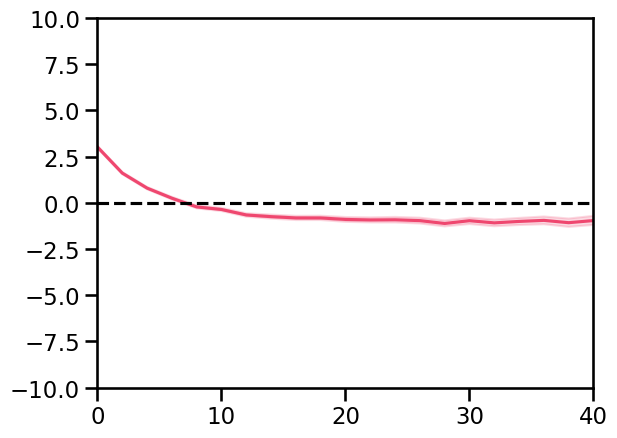

In [27]:
N = 1000
continuation_diffs = (continuation[1:] - continuation[:-1])
#sns.regplot(
#    x=continuation[:-1, :N].flatten(),
#    y=continuation_diffs[:, :N].flatten(),
#    scatter_kws={'alpha': 0.05, 'color': colors[1]},
#    fit_reg=False,
#)

sns.lineplot(
    x=2*(continuation[:-1, :N].flatten()//2).round(),
    y=continuation_diffs[:, :N].flatten(),
    color=colors[0],
)

plt.axhline(0, linestyle='--', color='black')
plt.xlim([0, 40])
plt.ylim([-10, 10])